# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.
import numpy as np

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


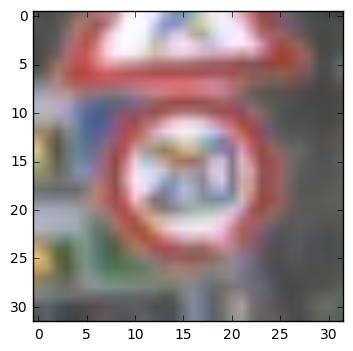

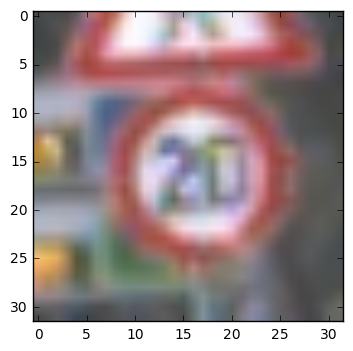

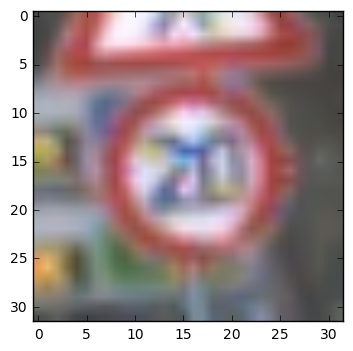

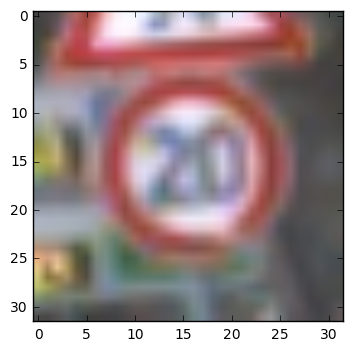

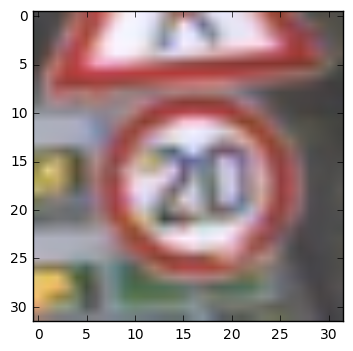

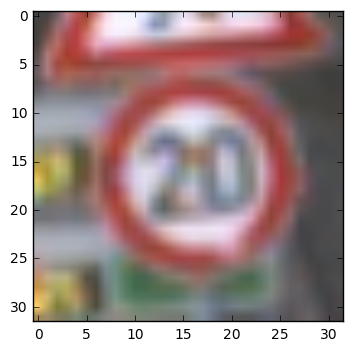

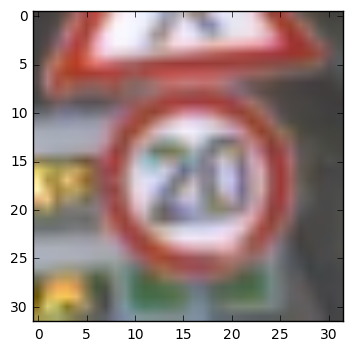

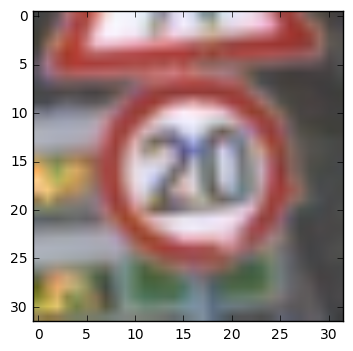

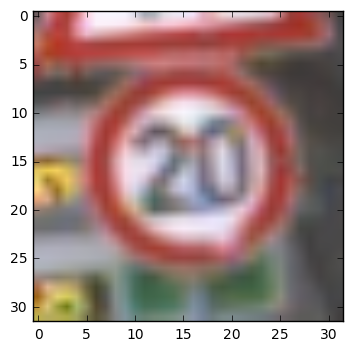

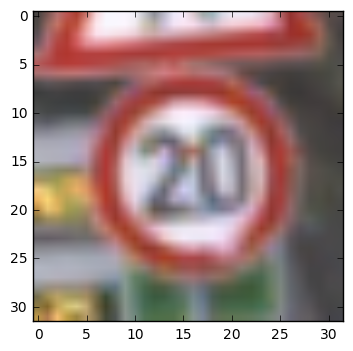

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

for i in range(10):
    plt.figure()
    plt.imshow(X_train[i])

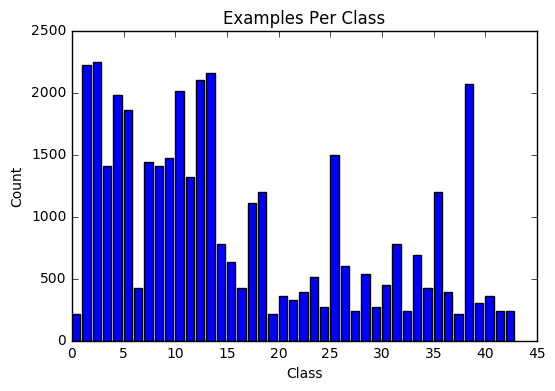

In [4]:
def graph_examples_per_class(unhot_labels):
    values, counts = np.unique(unhot_labels, return_counts=True)
    plt.figure()
    plt.bar(values, counts)
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.title('Examples Per Class')
    plt.show()
    
graph_examples_per_class(y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Train Shape:   (39209, 32, 32, 1)
Labels Shape:  (39209, 43)


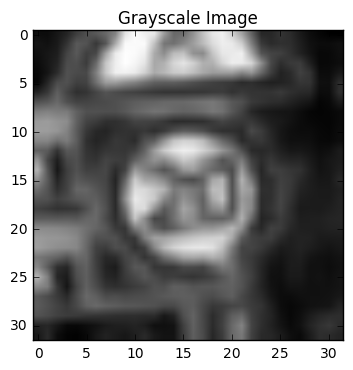

In [42]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2
import pandas

image_size = 32
num_labels = n_classes
num_channels = 1 # grayscale

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255

def reformat_dataset(dataset):
    if num_channels == 1:
        dataset = np.asarray([grayscale(img) for img in dataset])
    dataset = dataset.reshape(
      (-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset

def reformat(dataset, labels):
    dataset = reformat_dataset(dataset)
    labels = onehot(labels)
    return dataset, labels

def rebalance(dataset, labels, oversample_factor=3):
    # Resample the dataset, with a uniform distribution over each class
    label_values = unhot(labels)
    values, counts = np.unique(label_values, return_counts=True)
    weight = (counts.max() / counts)
    p = np.asarray([weight[v] for v in label_values])
    p = p / p.sum()
    choices = np.random.choice(
        len(dataset),
        size=counts.max() * oversample_factor * num_labels,
        p=p
    )
    return dataset[choices], labels[choices]

def onehot(labels):
    return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

def unhot(labels):
    return np.argmax(labels, axis=1)

train, labels = reformat(X_train, y_train)
test_data, test_labels = reformat(X_test, y_test)

print("Train Shape:  ", train.shape)
print("Labels Shape: ", labels.shape)

plt.title('Grayscale Image')
plt.imshow(train[0].reshape((32, 32)), cmap='gray')
plt.show()

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** To preprocess the data, I reformat the images into single-color-channel grayscale images using cv2, and normalize them so all values are between 0 and 1.  For the labels, I one-hot encode them.  

I chose to use a single color because doing so reduces the training time, at the expense of a little accuracy (< 0.2% on the validation set, in my tests).  I chose to normalize the values by scaling them to avoid numerical stability issues and provide the optimizer with a well-conditioned problem.

(31367, 32, 32, 1)
(31367, 32, 32, 1)


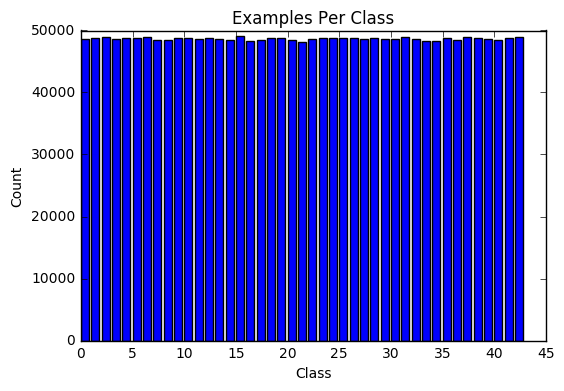

In [23]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.cross_validation import train_test_split

def generate_noise(data, noise_std_prop=0.01):
    return np.random.normal(scale=(data.max()-data.min()) * noise_std_prop, size=data.shape)

def add_noise(data, labels, image_count):
    """Generates noise_image_count images per original image, returning the original
    data with the new noisy images.
    """
    noisy_data = []
    for _ in range(image_count):
        noise = generate_noise(train_data)
        noisy_data.append(train_data + noise)
    return np.concatenate([data] + noisy_data), np.concatenate([labels] * (1 + image_count))

def add_perspective(data, labels, image_count):
    perspective_data = []
    original = np.float32([[0,0], [31,0], [0,31], [31,31]])
    for _ in range(image_count):
        new_imgs = []
        for img in data:            
            new = np.float32([
                [np.random.randint(6),np.random.randint(6)], 
                [31-np.random.randint(6),np.random.randint(6)], 
                [np.random.randint(6),31-np.random.randint(6)], 
                [31-np.random.randint(6),31-np.random.randint(6)]
            ])
            M = cv2.getPerspectiveTransform(original, new)
            new_img = cv2.warpPerspective(img,M,(32,32)).reshape(32,32,1)
            new_imgs.append(new_img)
        
        perspective_data.append(np.asarray(new_imgs))
    return np.concatenate([data] + perspective_data), np.concatenate([labels] * (1 + image_count))
    
    
train_data, validation_data, train_labels, validation_labels = train_test_split(train, labels, train_size=0.8)

train_data, train_labels = add_perspective(train_data, train_labels, 2)
train_data, train_labels = add_noise(train_data, train_labels, 2)

train_data, train_labels = rebalance(train_data, train_labels)
graph_examples_per_class(unhot(train_labels))

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** I split the provided training data into a training and validation set, with 20% of the data going into the validation set, and 80% staying in the training set.  

I generated additional data by perspective shifting each image twice, tripling the training set size.  The perspective shifted images move each image corner toward the center of the image by a random value, from 0 to 5 pixels.  I then add a normally distributed random amount of noise (mean 0, std dev 1%) to each image, to generate two additional noisy images for each, again tripling the training set size, to nine times the original size.

Lastly, I oversample from the training set, weighting each image so the final distribution will be approximately uniform across classes, as shown in the graph above.  The sample is randomly drawn (i.e. train_data is ordered randomly by label).  I chose to oversample so that there is a good chance of some examples from each input training image making it into the final sample.

By generating additional data, I was able to increase test performance from about 92% to over 95% accuracy.  The perspective shifts and the noise encourage the algorithm to generalize more, since irrelevant details change while the core content remains the same.  Even with the synthetic data, the smallest original classes still have fewer examples than the most popular ones started with, resulting in a significant number of duplicates in the oversample step.  Performance could likely be improved further by generating additional synthetic data for the underrepresented classes, and using different techniques to generate synthetic data.

In [46]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import math

batch_size = 128
eval_size = 5
patch_size = 5 # 10
depth = 16
num_hidden = 128
keep_prob = 0.75
beta = 0.0001
init_value = 0.04
# init_value = math.sqrt(2.0 / len(train_data))

graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(validation_data)
    tf_test_dataset = tf.constant(test_data)
    tf_eval_dataset = tf.placeholder(tf.float32, shape=(eval_size, image_size, image_size, num_channels))

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=init_value))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=init_value))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=init_value))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden], stddev=init_value))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden], stddev=init_value))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer6_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=init_value))
    layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data, include_dropout=False):
        def relu(val):
            if include_dropout:
                return tf.nn.relu(tf.nn.dropout(val, keep_prob))
            else:
                return tf.nn.relu(val)

        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        hidden = relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
        hidden = relu(tf.matmul(hidden, layer5_weights) + layer5_biases)    
        return tf.matmul(hidden, layer6_weights) + layer6_biases

    # Training computation.
    logits = model(tf_train_dataset, include_dropout=True)
    l2_loss = (
        tf.nn.l2_loss(layer1_weights) + 
        tf.nn.l2_loss(layer2_weights) + 
        tf.nn.l2_loss(layer3_weights) + 
        tf.nn.l2_loss(layer4_weights) + 
        tf.nn.l2_loss(layer5_weights) + 
        tf.nn.l2_loss(layer6_weights)
    )
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta * l2_loss

    # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    eval_prediction = tf.nn.softmax(model(tf_eval_dataset))
    
    # Saver
    saver = tf.train.Saver()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The final network architecture is deep convolutional neural network composed of a linear list of layers, starting with two [convolution, relu, max pool] sets, then 4 fully-connected layers using relus for activation.  The convolution layers are using a patch size of 5, a depth of 16, and a stride of 1.  The max pool layers are using a stride of 2. 

The input layer is [32, 32, 1], which is changed to [16, 16, 16] after the first max pooling operation.  After the second operation, the size drops to [8, 8, 16].  All of the fully connected layers are size [128], and the output layer is [43].  Dropout is used on the fully-connected hidden layers, along with minimal l2 regularization to prevent overfitting.

In [49]:
### Train your model here.
### Feel free to use as many code cells as needed.

num_steps = 30001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), validation_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    
    print('Saving')
    saver.save(session, "model.ckpt")

Initialized
Minibatch loss at step 0: 3.971073
Minibatch accuracy: 0.8%
Validation accuracy: 5.7%
Minibatch loss at step 50: 3.788697
Minibatch accuracy: 3.1%
Validation accuracy: 1.6%
Minibatch loss at step 100: 3.676960
Minibatch accuracy: 5.5%
Validation accuracy: 2.9%
Minibatch loss at step 150: 3.605762
Minibatch accuracy: 7.0%
Validation accuracy: 2.7%
Minibatch loss at step 200: 3.583560
Minibatch accuracy: 6.2%
Validation accuracy: 3.5%
Minibatch loss at step 250: 3.566239
Minibatch accuracy: 6.2%
Validation accuracy: 2.9%
Minibatch loss at step 300: 3.528465
Minibatch accuracy: 7.0%
Validation accuracy: 4.7%
Minibatch loss at step 350: 3.345657
Minibatch accuracy: 10.9%
Validation accuracy: 6.6%
Minibatch loss at step 400: 2.863912
Minibatch accuracy: 18.8%
Validation accuracy: 10.1%
Minibatch loss at step 450: 2.714263
Minibatch accuracy: 21.9%
Validation accuracy: 17.0%
Minibatch loss at step 500: 2.498039
Minibatch accuracy: 25.8%
Validation accuracy: 24.6%
Minibatch loss a

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


In [116]:
print(len(train_data))
print(batch_size * num_steps)
print((batch_size * num_steps)/len(train_data))
print((batch_size * num_steps)/(len(y_train)*0.8))

2093283
3840128
1.8345001607522728
122.424953454564


**Answer:** My model is trained using the adam optimizer, with a batch size of 128.  I dropout 25% of activations from fully-connected hidden layers.  I also include minimal l2 regularization with a weight of 0.0001.  I train on 30001 batches, which is a bit less than 1.85 epochs through the synthetic train_data.  Because of the volume of synthetic data, that corresponds to a little more than 122 epochs of the original data.

During the development process, I iterated on the model training 10,000 steps for each model iteration.  I observed that the model would continue improving slightly if run for more iterations, so once I selected a final model architecture, I re-trained my best model architecture for an additional 20,000 steps, resulting in a gain in validation and test accuracy of about 1% over the base performance.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** My thought process in choosing the network architecture was largely iterative, testing new architectures and making modifications, then measuring the resulting gain or loss in accuracy.  I added layers until the model started overfitting (meaning it was complex enough to learn the data), then I tuned the regularization and dropout hyperparameters to eliminate the overfitting and get the model to generalize on the validation set.  The initial training accuracy, without tuning dropout and regularization, was about 89%.  I adjusted the patch size and depth of the convolutional layers, but couldn't achieve higher performance by raising or lowering those values.  The convolutions and max-pooling layers converted the 32x32 images to a deeper 8x8x16 representation, squeezing out most of the the spatial information.  Adding an additional convolutional layer also did not result in an accuracy improvement.

I stopped getting significant gains from adjusting the network architecture and hyperparameters with an accuracy of about 92%.  I then did some synthetic data generation to bring the accuracy higher, to above 95%.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

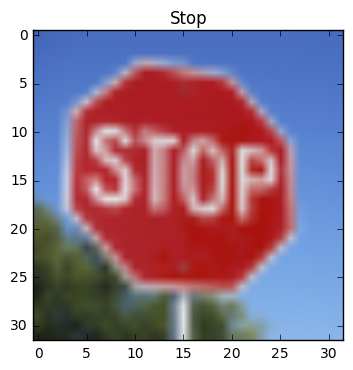

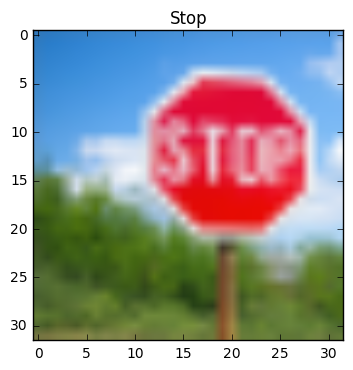

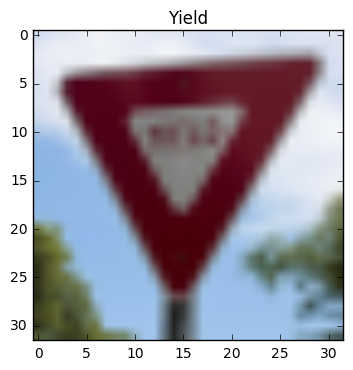

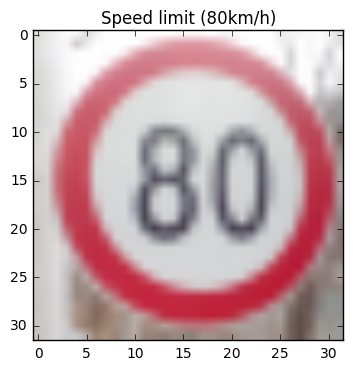

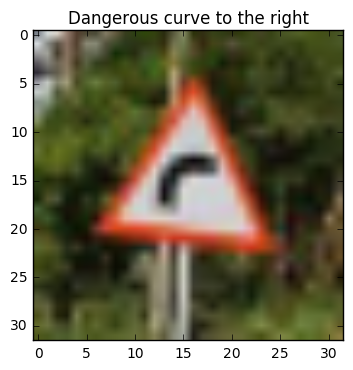

In [54]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from os import listdir

classes = """Speed limit (20km/h)
Speed limit (30km/h)
Speed limit (50km/h)
Speed limit (60km/h)
Speed limit (70km/h)
Speed limit (80km/h)
End of speed limit (80km/h)
Speed limit (100km/h)
Speed limit (120km/h)
No passing
No passing for vechiles over 3.5 metric tons
Right-of-way at the next intersection
Priority road
Yield
Stop
No vechiles
Vechiles over 3.5 metric tons prohibited
No entry
General caution
Dangerous curve to the left
Dangerous curve to the right
Double curve
Bumpy road
Slippery road
Road narrows on the right
Road work
Traffic signals
Pedestrians
Children crossing
Bicycles crossing
Beware of ice/snow
Wild animals crossing
End of all speed and passing limits
Turn right ahead
Turn left ahead
Ahead only
Go straight or right
Go straight or left
Keep right
Keep left
Roundabout mandatory
End of no passing
End of no passing by vechiles over 3.5 metric tons"""

classes = classes.split("\n")

sign_to_class_map = {
    "80.jpg": 5,
    "curveright.jpg": 20,
    "stop1.jpg": 14,
    "stop2.jpg": 14,
    "us_yield.jpg": 13
}

imgs = []
img_classes = []
for imgname in listdir('signs'):
    img = cv2.imread('signs/' + imgname)
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
    # BGR TO RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    img_classes.append(sign_to_class_map[imgname])
    
for img, img_class in zip(imgs, img_classes):
    plt.figure()
    plt.title(classes[img_class])
    plt.imshow(img)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** The images are plotted above.  I think the yield sign could be difficult, since it's a US Yield sign instead of a German one, so it includes YIELD text.  The 80 kmph sign could also be difficult because 80 is kind of close to 30 in appearance.  The last image could also be difficult, as the color appears to be a little off from other images in the dataset, it is a little heavy on the artifacts, and there weren't that many original training examples for this class.

In [68]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session(graph=graph) as session:
    saver.restore(session, "model.ckpt")
    feed_dict = {tf_eval_dataset: reformat_dataset(imgs)}
    [predictions] = session.run([eval_prediction], feed_dict=feed_dict)

for pred, actual_class in zip(predictions, img_classes):
    predicted = np.argmax(pred)
    print("Predicted: ", predicted, "  Actual: ", actual_class)
    print("Predicted: ", classes[predicted], "  Actual: ", classes[actual_class])
    print("")

Predicted:  14   Actual:  14
Predicted:  Stop   Actual:  Stop

Predicted:  14   Actual:  14
Predicted:  Stop   Actual:  Stop

Predicted:  13   Actual:  13
Predicted:  Yield   Actual:  Yield

Predicted:  2   Actual:  5
Predicted:  Speed limit (50km/h)   Actual:  Speed limit (80km/h)

Predicted:  26   Actual:  20
Predicted:  Traffic signals   Actual:  Dangerous curve to the right



### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** My model obtained 95.5% accuracy on the test-set, but only 60% accuracy (3 of 5) on the 5 images that I manually selected.  My model would not perform very well on captured pictures or a live camera stream.  The 32x32 images are largely already focused on the signs.  Modifying the model so it's fed 32x32 patches of a larger image could possibly work.

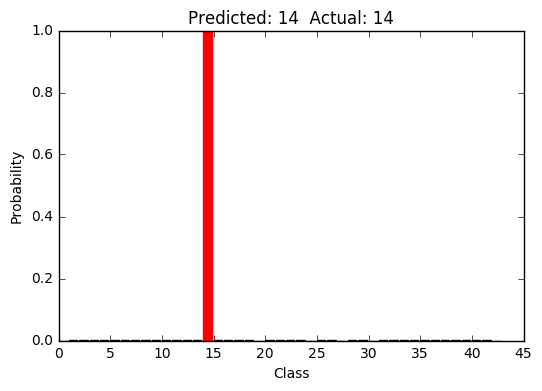

Probability of Actual Class:  0.999991
nth highest probability class:  1
Training examples for class:  780.0







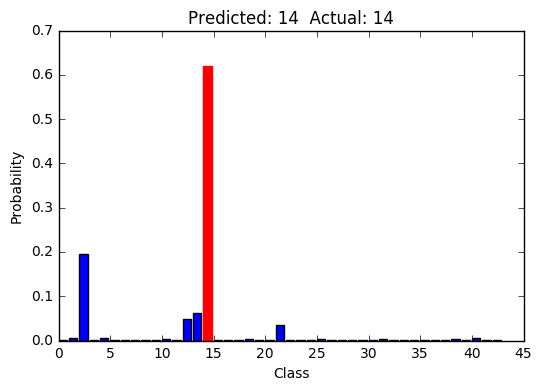

Probability of Actual Class:  0.618753
nth highest probability class:  1
Training examples for class:  780.0







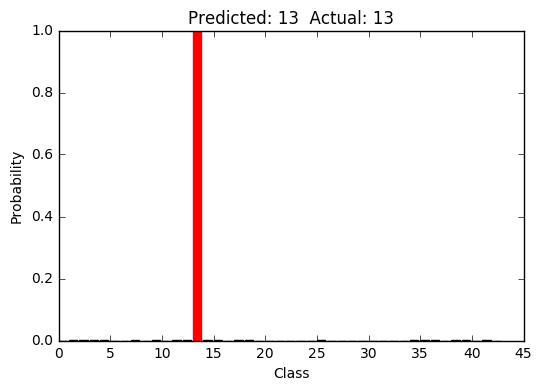

Probability of Actual Class:  1.0
nth highest probability class:  1
Training examples for class:  2160.0







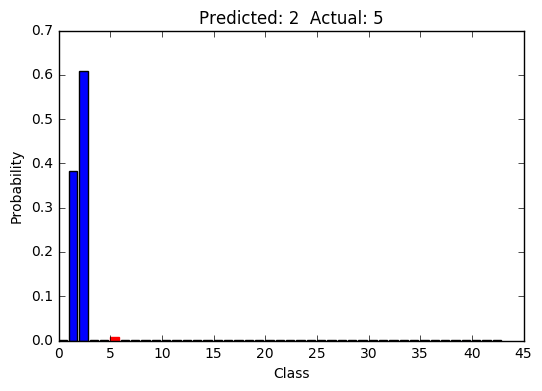

Probability of Actual Class:  0.00705655
nth highest probability class:  3
Training examples for class:  1860.0







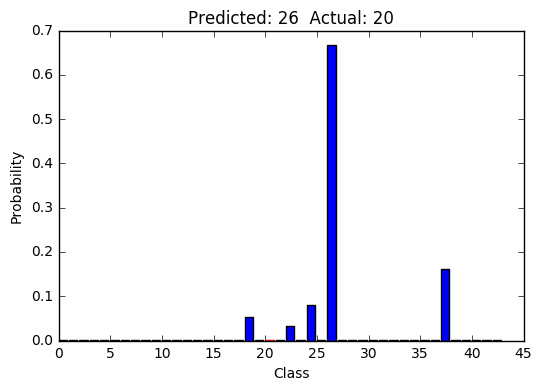

Probability of Actual Class:  5.3376e-05
nth highest probability class:  17
Training examples for class:  360.0







In [108]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

for pred, actual_class in zip(predictions, img_classes):
    predicted = np.argmax(pred)
    probabilities = pred / pred.sum()
    
    top_probabilities = np.arange(43)
    top_probabilities = top_probabilities[np.argsort(probabilities[top_probabilities])][::-1]
    
    plt.title("Predicted: " + str(predicted) + "  Actual: " + str(actual_class))
    barlist=plt.bar(np.arange(43), probabilities)
    barlist[actual_class].set_color('r')
    plt.ylabel("Probability")
    plt.xlabel("Class")
    plt.show()
    
    order = np.argwhere(top_probabilities==actual_class)[0][0]
    
    print("Probability of Actual Class: ", probabilities[actual_class])
    print("nth highest probability class: ", order+1)
    print("Training examples for class: ", (y_train == actual_class).astype(np.float32).sum())
    print("\n\n\n\n")

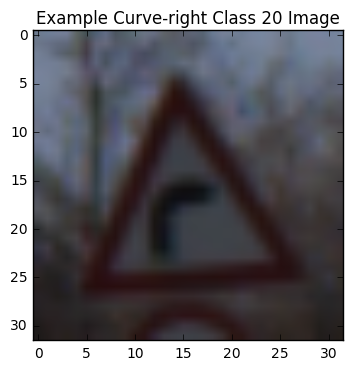

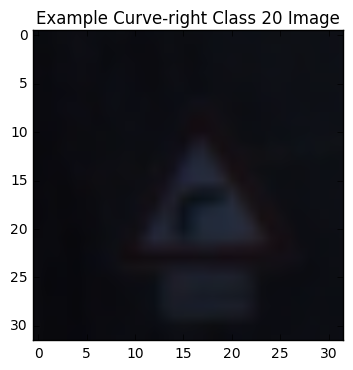

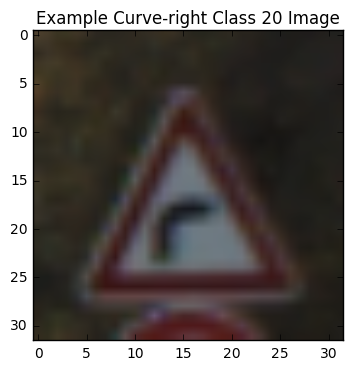

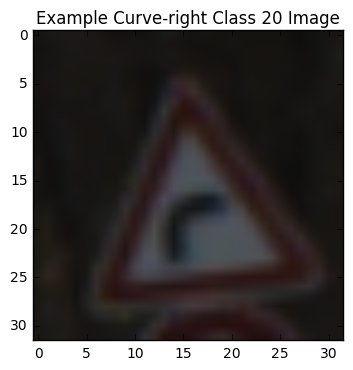

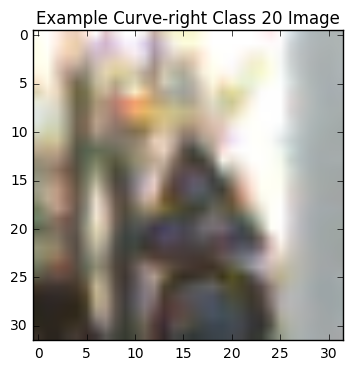

In [111]:
curverightimgs = X_train[y_train==20]
for i in np.random.choice(np.arange(len(curverightimgs)), size=5):
    plt.figure()
    plt.title("Example Curve-right Class 20 Image")
    plt.imshow(curverightimgs[i])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** I visualized the probability per class above, with the actual class highlighted in red.  The model is almost totally certain of the first and third prediction, and highly certain about the second.  The model misses the 4th and 5th predictions.  For the 4th prediction, the model does assign the 3rd highest probability to the actual class, but it's less than 1% - the model thinks 30 or 50 is much more likely than 80, which is still somewhat close.  For the final prediciton, the model is very far off, identifying the actual class with the 17th highest probability.  There are many fewer training examples for the actual class in this case, which could be a contributing factor. 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** The code at the start of Step 3 will read square images from the signs directory, then use cv2 to resize them to 32x32, and recolor them to RGB.  I also call my reformat data function on them before passing them to the model, so that they're grayscaled and normalized in the same way the training data was.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.